In [11]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
session=sagemaker.Session()
role=get_execution_role()

In [12]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
bostondata = load_boston()
X,y=pd.DataFrame(bostondata.data,columns=bostondata.feature_names),pd.DataFrame(bostondata.target)

In [14]:
# !mkdir data

In [15]:
# Convert data to make it kosher for sagemaker
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.33)
pd.concat([y_train,X_train],axis=1).to_csv('data/train.csv',header=False,index=False)
pd.concat([y_val,X_val],axis=1).to_csv('data/validation.csv',header=False,index=False)
X_test.to_csv('data/test.csv',header=False,index=False)

In [16]:
# upload to S3
prefix='boston-xgboost-HL'
session.upload_data('data',key_prefix=prefix)

's3://sagemaker-us-east-1-032934527328/boston-xgboost-HL'

In [17]:
# !pip uninstall -f sagemaker
# !pip install sagemaker==1.72.0
# sagemaker.__version__

In [18]:
# for latest sagemaker >2 
# container=sagemaker.image_uris.retrieve('xgboost',session.boto_region_name)
container=get_image_uri(session.boto_region_name,'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [19]:
xgb=sagemaker.estimator.Estimator(container,
                                  get_execution_role(),
                                 train_instance_count=1,
                                 train_instance_type='ml.m5.large',
                                 output_path='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/output',
                                 sagemaker_session=session,
                                train_use_spot_instances=True,
                                  train_max_wait=3600,train_max_run=3600
                                 )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [20]:
xgb.set_hyperparameters(max_depth=5,
                       eta=0.2,
                       gamma=4,
                       min_child_weight=6,
                       subsample=0.8,
                       objective='reg:linear',
                       early_stopping_rounds=10,
                       num_round=200)

In [21]:
# Wrapper so sagemaker knows data is in csv
s3_input_train=sagemaker.s3_input(s3_data='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/train.csv',
                                  content_type='csv')
s3_input_validation=sagemaker.s3_input(s3_data='s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/validation.csv',
                                  content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [22]:
xgb.fit({'train':s3_input_train,'validation':s3_input_validation})

2021-04-08 21:45:46 Starting - Starting the training job...
2021-04-08 21:45:47 Starting - Launching requested ML instances......
2021-04-08 21:47:06 Starting - Preparing the instances for training......
2021-04-08 21:48:11 Downloading - Downloading input data...
2021-04-08 21:48:46 Training - Downloading the training image...
2021-04-08 21:49:13 Uploading - Uploading generated training model
2021-04-08 21:49:13 Completed - Training job completed
Arguments: train
[2021-04-08:21:49:01:INFO] Running standalone xgboost training.
[2021-04-08:21:49:01:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 187.38mb
[2021-04-08:21:49:01:INFO] Determined delimiter of CSV input is ','
[21:49:01] S3DistributionType set as FullyReplicated
[21:49:01] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-04-08:21:49:01:INFO] Determined delimiter of CSV input is ','
[21:49:01] S3DistributionType set as F

Training seconds: 62
Billable seconds: 25
Managed Spot Training savings: 59.7%


In [23]:
xgb_transformer=xgb.transformer(instance_count=1,instance_type='ml.m5.large')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [25]:
xgb_transformer.transform('s3://sagemaker-us-east-1-032934527328/boston-xgboost-HL/test.csv',
                          content_type='text/csv',
                          split_type='Line')

In [26]:
xgb_transformer.wait()

......................Arguments: serve
[2021-04-08 21:54:44 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-04-08 21:54:44 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-04-08 21:54:44 +0000] [1] [INFO] Using worker: gevent
[2021-04-08 21:54:44 +0000] [20] [INFO] Booting worker with pid: 20
[2021-04-08 21:54:45 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subprocess=True)
[2021-04-08:21:54:45

In [27]:
!aws s3 cp --recursive $xgb_transformer.output_path data/

download: s3://sagemaker-us-east-1-032934527328/xgboost-2021-04-08-21-51-02-752/test.csv.out to data/test.csv.out


In [28]:
y_pred=pd.read_csv('data/test.csv.out',header=None)

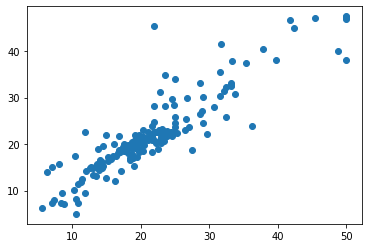

In [29]:
plt.scatter(y_test,y_pred)

In [30]:
xgb_transformer.output_path

's3://sagemaker-us-east-1-032934527328/xgboost-2021-04-08-21-51-02-752'